In [1]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import necessary libraries
import json
import pandas as pd

# STEP 3: Load the JSON file
json_path = "/content/drive/MyDrive/reviews.json"  # adjust if needed
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# STEP 4: Flatten the nested structure into a DataFrame
flattened_reviews = []

for paper in data['paper']:
    paper_id = paper.get('id')
    preliminary_decision = paper.get('preliminary_decision')

    for review in paper['review']:
        flattened_review = {
            'paper_id': paper_id,
            'preliminary_decision': preliminary_decision,
            'review_id': review.get('id'),
            'confidence': review.get('confidence'),
            'evaluation': review.get('evaluation'),
            'orientation': review.get('orientation'),
            'language': review.get('lan'),
            'remarks': review.get('remarks'),
            'text': review.get('text'),
            'timespan': review.get('timespan')
        }
        flattened_reviews.append(flattened_review)

# STEP 5: Create the DataFrame
df = pd.DataFrame(flattened_reviews)
print("✅ Flattened DataFrame created. Shape:", df.shape)
print(df.head(2))


Mounted at /content/drive
✅ Flattened DataFrame created. Shape: (405, 10)
   paper_id preliminary_decision  review_id confidence evaluation orientation  \
0         1               accept          1          4          1           0   
1         1               accept          2          4          1           1   

  language remarks                                               text  \
0       es          - El artículo aborda un problema contingente y...   
1       es          El artículo presenta recomendaciones prácticas...   

     timespan  
0  2010-07-05  
1  2010-07-05  


STEP 2: TEXT CLEANING & PREPROCESSING

In [2]:
# STEP 6: Install and import NLP libraries
!pip install nltk spacy
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm

import string
import re
import spacy
import nltk
from nltk.corpus import stopwords

# STEP 7: Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# STEP 8: Load language models and stopwords
nlp_es = spacy.load('es_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')

spanish_stopwords = set(stopwords.words('spanish'))
english_stopwords = set(stopwords.words('english'))

# STEP 9: Clean & preprocess text
def preprocess_text(text, language='es'):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    if language == 'es':
        doc = nlp_es(text)
        stopwords_lang = spanish_stopwords
    else:
        doc = nlp_en(text)
        stopwords_lang = english_stopwords

    tokens = [token.lemma_ for token in doc if token.text not in stopwords_lang and not token.is_space]
    return ' '.join(tokens)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 70.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


APPLY CLEANING + REMOVE EMPTY REVIEWS

In [3]:
# STEP 10: Split data by language
df_spanish = df[df['language'] == 'es'].copy()
df_english = df[df['language'] == 'en'].copy()

# STEP 11: Apply preprocessing
df_spanish['cleaned_text'] = df_spanish['text'].apply(preprocess_text, language='es')
df_english['cleaned_text'] = df_english['text'].apply(preprocess_text, language='en')

# STEP 12: Combine preprocessed data
df_cleaned = pd.concat([
    df_spanish[['text', 'cleaned_text', 'language', 'confidence', 'evaluation', 'orientation']],
    df_english[['text', 'cleaned_text', 'language', 'confidence', 'evaluation', 'orientation']]
], ignore_index=True)

# STEP 13: Create empty flag and drop truly empty reviews
df_cleaned['empty_cleaned'] = df_cleaned['cleaned_text'].apply(lambda x: x.strip() == "")
df_cleaned = df_cleaned[df_cleaned['empty_cleaned'] == False].reset_index(drop=True)

print("✅ Cleaned reviews shape:", df_cleaned.shape)
print(df_cleaned[['cleaned_text', 'language', 'orientation']].head())



#Length-Based Features

# Add word count and char count
df_cleaned['word_count'] = df_cleaned['cleaned_text'].apply(lambda x: len(str(x).split()))
df_cleaned['char_count'] = df_cleaned['text'].apply(lambda x: len(str(x)))

# Preview
print(df_cleaned[['cleaned_text', 'word_count', 'char_count']].head())

✅ Cleaned reviews shape: (399, 7)
                                        cleaned_text language orientation
0  artículo abordar problema contingente relevant...       es           0
1  artículo presentar recomendación práctico desa...       es           1
2  tema interesante poder ser mucho ayuda guía in...       es           1
3  explicar forma ordenado didáctico experiencia ...       es           1
4  autor describir metodología desarrollar forma ...       es           0
                                        cleaned_text  word_count  char_count
0  artículo abordar problema contingente relevant...          45         575
1  artículo presentar recomendación práctico desa...          50         618
2  tema interesante poder ser mucho ayuda guía in...         118        1259
3  explicar forma ordenado didáctico experiencia ...         119        1350
4  autor describir metodología desarrollar forma ...         162        1938


STEP-2: EDA

I have divided it into four phases below

Phase 1: Class Distribution Analysis



<ipython-input-4-f77858ccc862>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='orientation', data=df_cleaned, palette='Set2')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


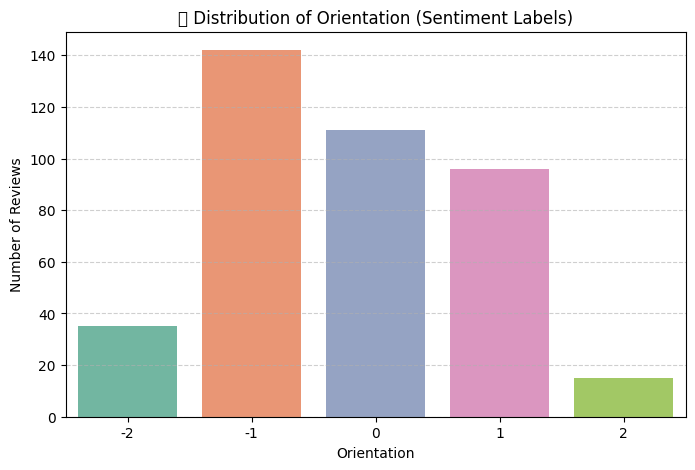

<ipython-input-4-f77858ccc862>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='evaluation', data=df_cleaned, palette='Set3')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


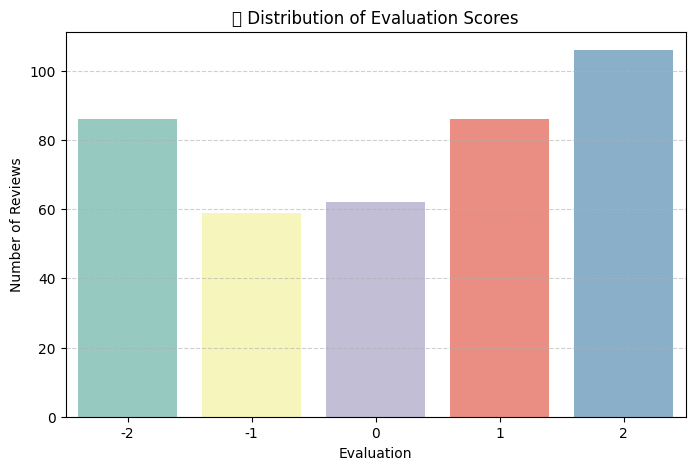

🔁 Crosstab: Orientation vs Evaluation
evaluation   -2  -1   0   1   2
orientation                    
-2           30   3   2   0   0
-1           50  45  31  11   5
 0            6  11  24  45  25
 1            0   0   5  29  62
 2            0   0   0   1  14


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


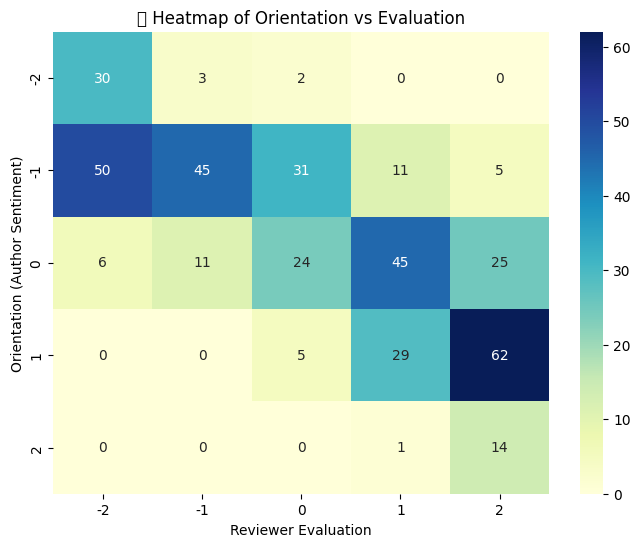

In [4]:
#Phase 1: Class Distribution Analysis
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert to numeric (in case they are object type)
df_cleaned['orientation'] = pd.to_numeric(df_cleaned['orientation'], errors='coerce')
df_cleaned['evaluation'] = pd.to_numeric(df_cleaned['evaluation'], errors='coerce')

# 1. Distribution of orientation (target label)
plt.figure(figsize=(8, 5))
sns.countplot(x='orientation', data=df_cleaned, palette='Set2')
plt.title("📊 Distribution of Orientation (Sentiment Labels)")
plt.xlabel("Orientation")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 2. Distribution of evaluation scores
plt.figure(figsize=(8, 5))
sns.countplot(x='evaluation', data=df_cleaned, palette='Set3')
plt.title("📊 Distribution of Evaluation Scores")
plt.xlabel("Evaluation")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 3. Heatmap: Crosstab between orientation and evaluation
comparison_ct = pd.crosstab(df_cleaned['orientation'], df_cleaned['evaluation'])
print("🔁 Crosstab: Orientation vs Evaluation")
print(comparison_ct)

plt.figure(figsize=(8, 6))
sns.heatmap(comparison_ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title("🧠 Heatmap of Orientation vs Evaluation")
plt.xlabel("Reviewer Evaluation")
plt.ylabel("Orientation (Author Sentiment)")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


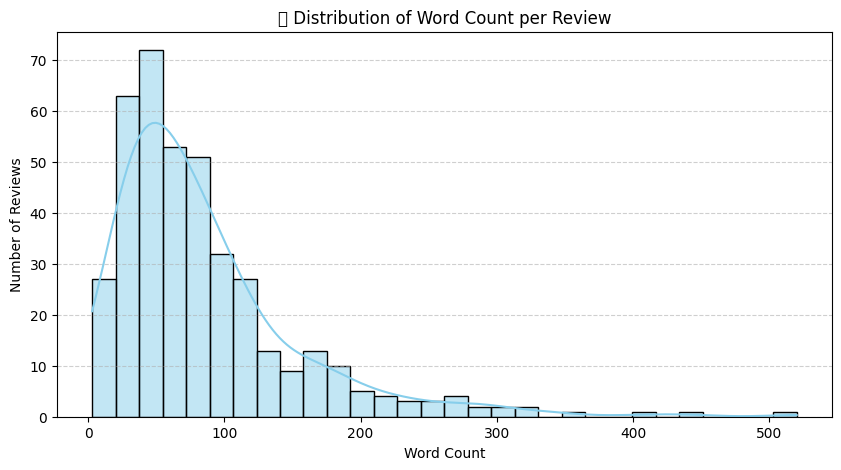

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


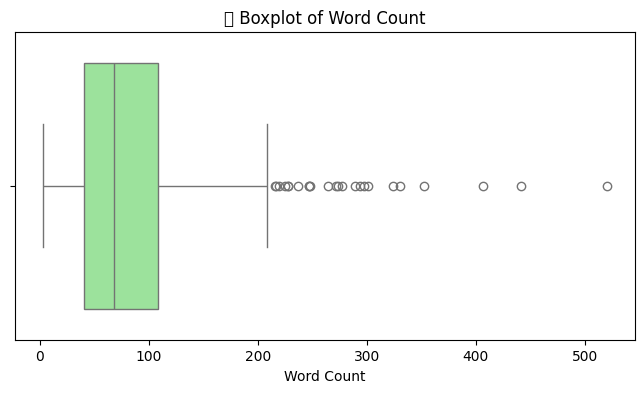

<ipython-input-5-09bf0a82718f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='orientation', y='word_count', data=df_cleaned, palette='Set2')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


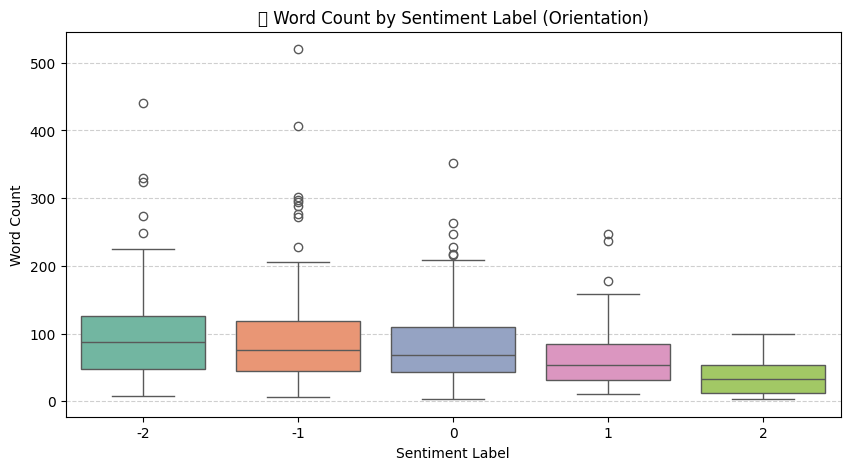

In [5]:
# Review Length Analysis
# 1. Histogram of word counts
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['word_count'], bins=30, kde=True, color='skyblue')
plt.title("📝 Distribution of Word Count per Review")
plt.xlabel("Word Count")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 2. Boxplot of word count
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_cleaned['word_count'], color='lightgreen')
plt.title("📦 Boxplot of Word Count")
plt.xlabel("Word Count")
plt.show()

# 3. Word Count by Sentiment
plt.figure(figsize=(10, 5))
sns.boxplot(x='orientation', y='word_count', data=df_cleaned, palette='Set2')
plt.title("🧠 Word Count by Sentiment Label (Orientation)")
plt.xlabel("Sentiment Label")
plt.ylabel("Word Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Phase 3: Most Frequent Words (Unigrams) + WordClouds

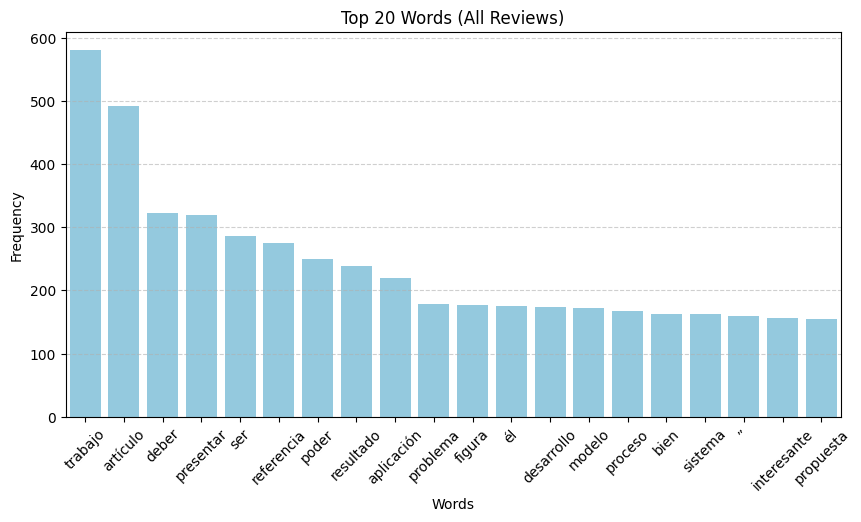

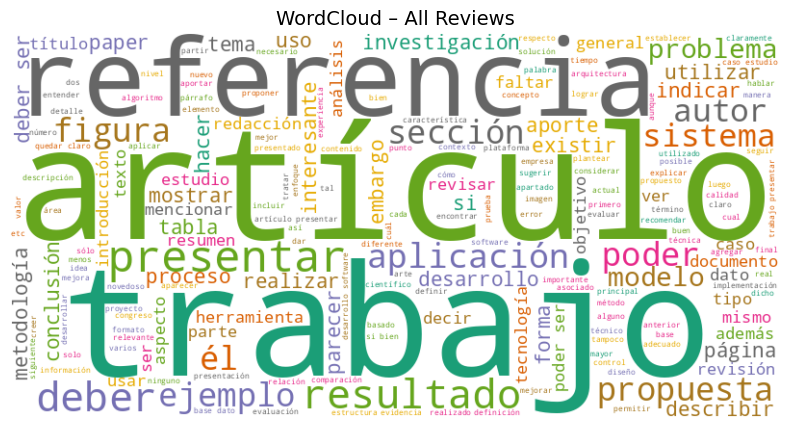

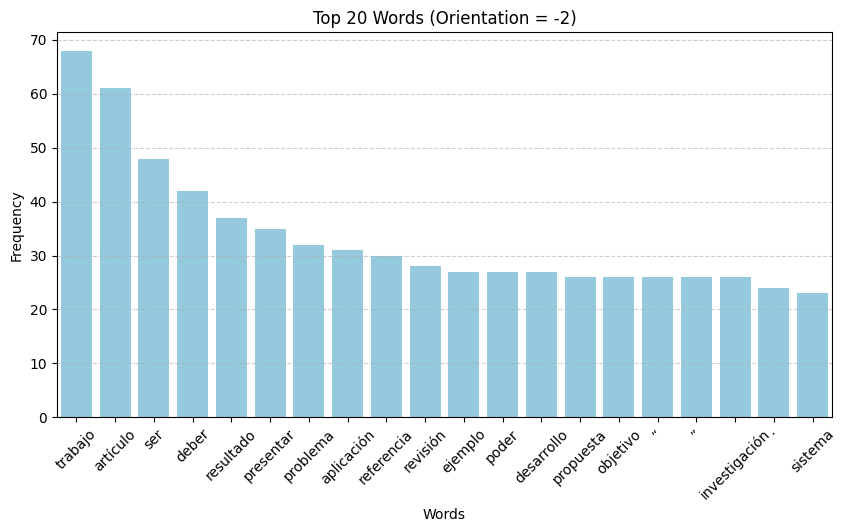

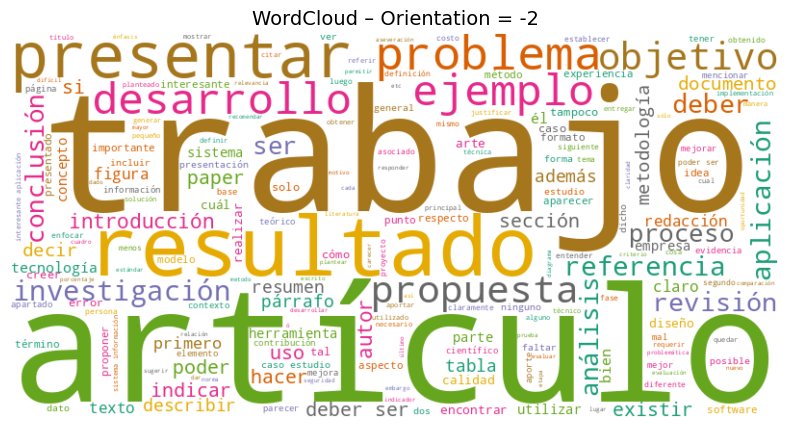

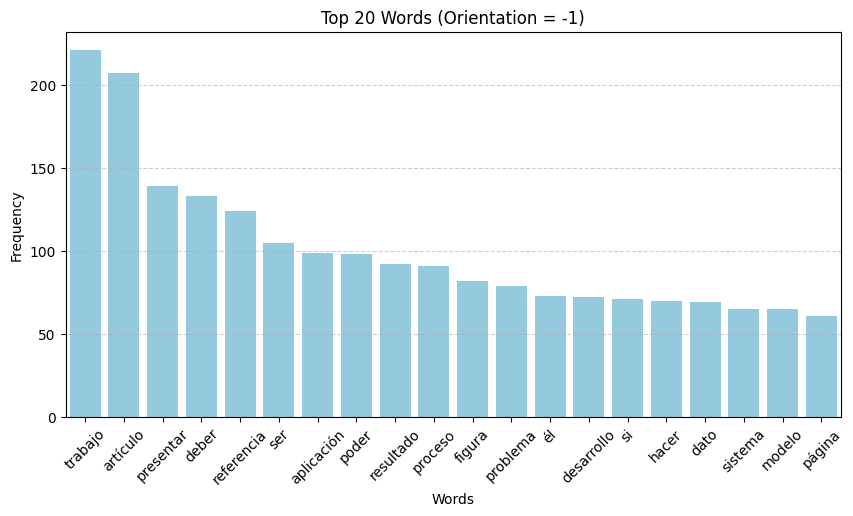

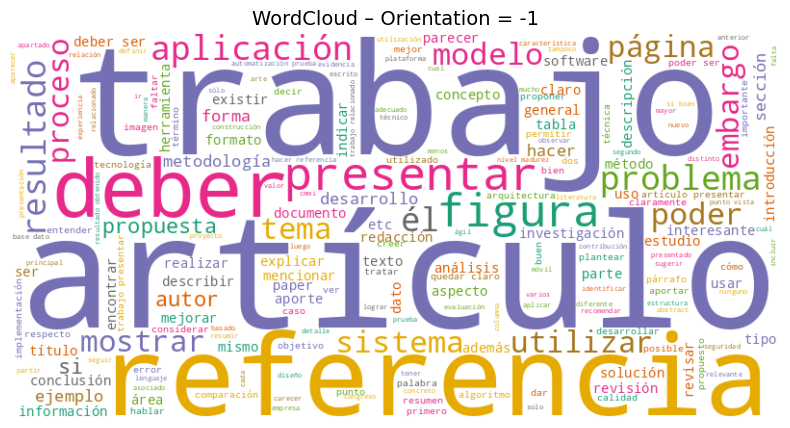

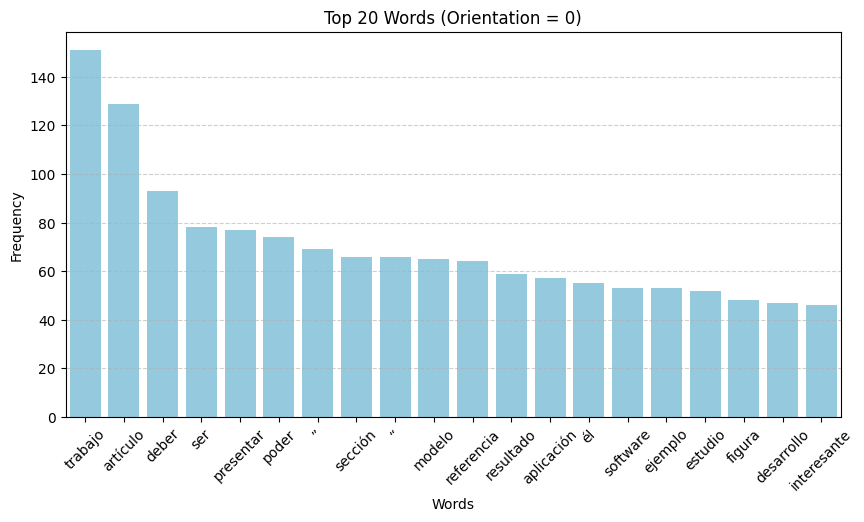

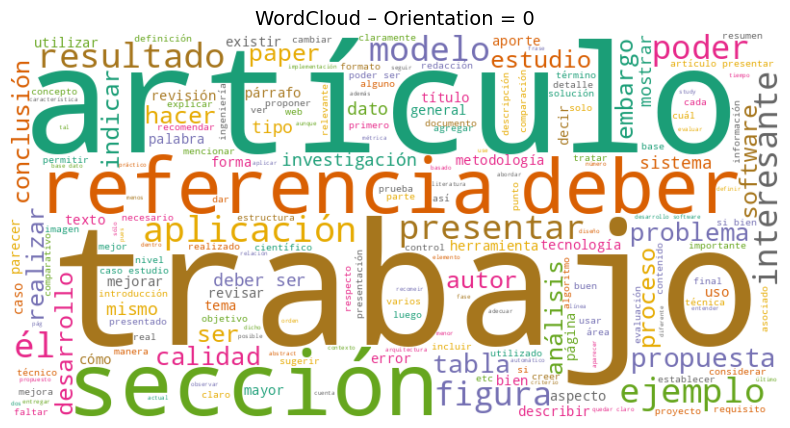

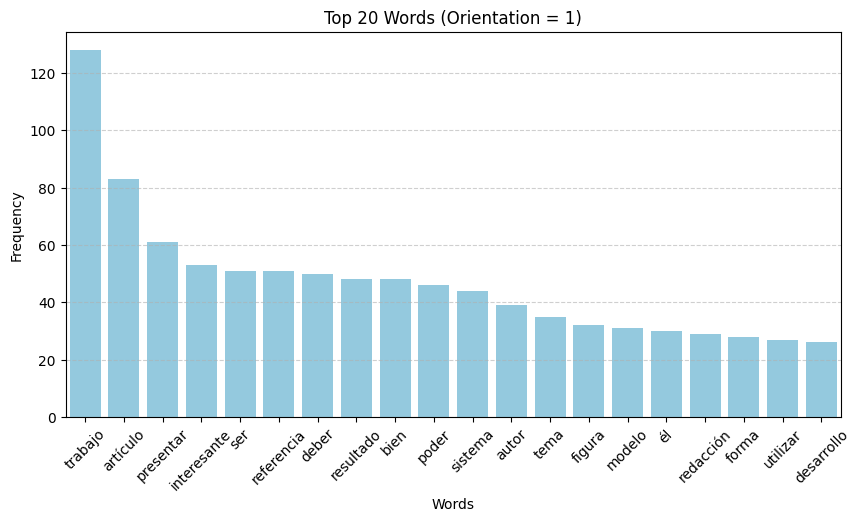

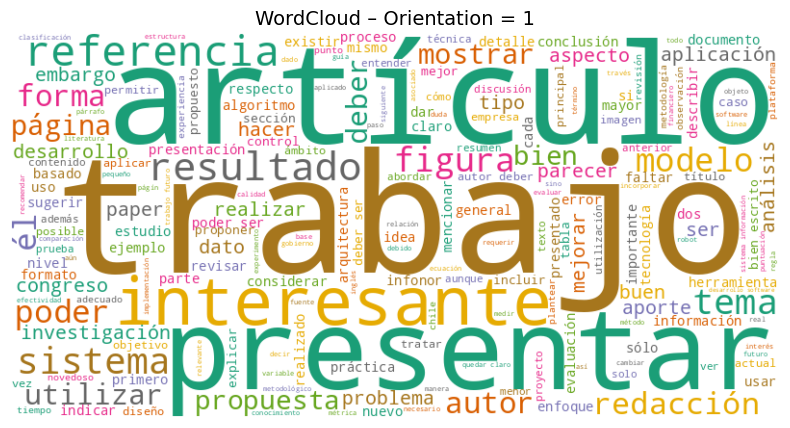

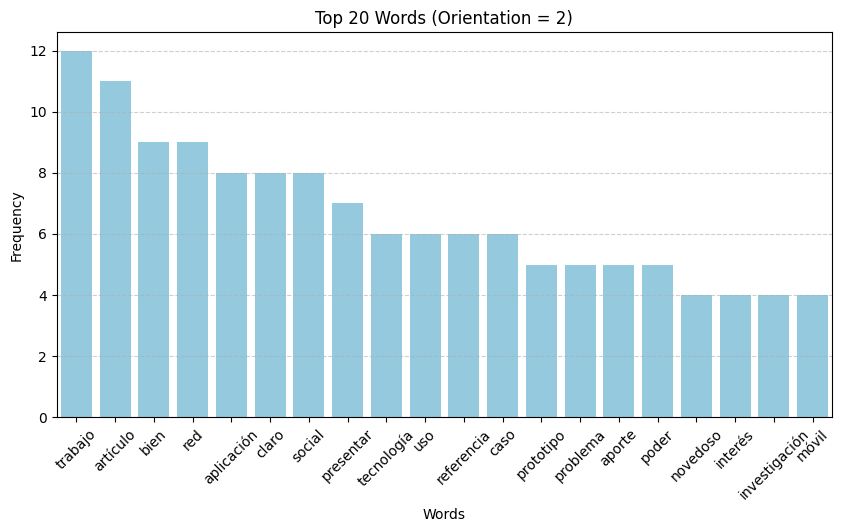

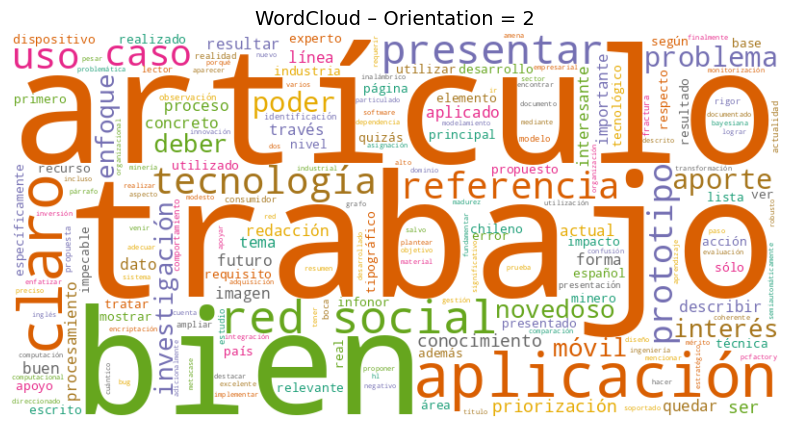

In [6]:
#Phase 3: Most Frequent Words (Unigrams) + WordClouds
from collections import Counter
from wordcloud import WordCloud

# Helper function
def get_top_n_words(corpus, n=20):
    words = " ".join(corpus).split()
    counter = Counter(words)
    return counter.most_common(n)

def plot_top_words(counter, title, color='skyblue'):
    words, counts = zip(*counter)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(words), y=list(counts), color=color)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

def plot_wordcloud(corpus, title):
    text = " ".join(corpus)
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

# All reviews
overall_top_words = get_top_n_words(df_cleaned['cleaned_text'], n=20)
plot_top_words(overall_top_words, "Top 20 Words (All Reviews)")
plot_wordcloud(df_cleaned['cleaned_text'], "WordCloud – All Reviews")

# Top words by sentiment
for sentiment in sorted(df_cleaned['orientation'].unique()):
    subset = df_cleaned[df_cleaned['orientation'] == sentiment]
    title = f"Orientation = {sentiment}"
    top_words = get_top_n_words(subset['cleaned_text'], n=20)
    plot_top_words(top_words, f"Top 20 Words ({title})")
    plot_wordcloud(subset['cleaned_text'], f"WordCloud – {title}")


Phase 4: N-gram Analysis (Bigrams & Trigrams)

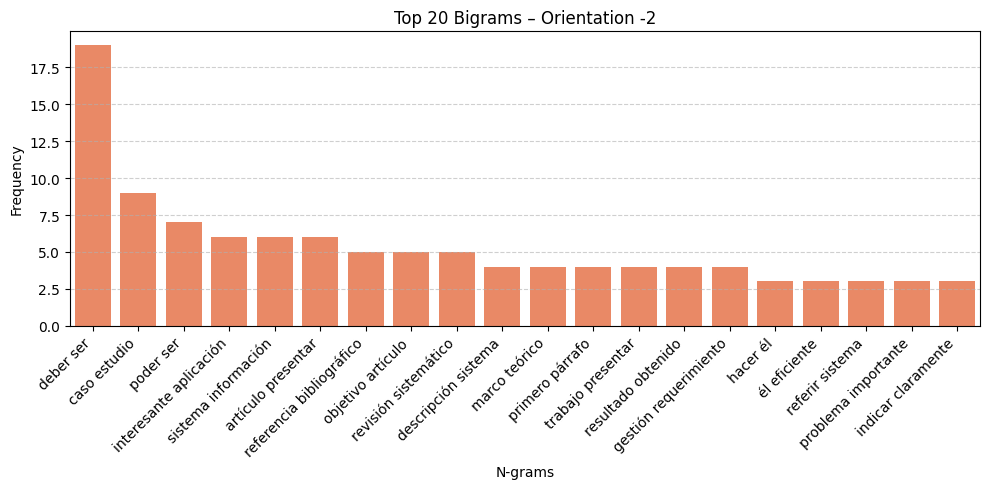

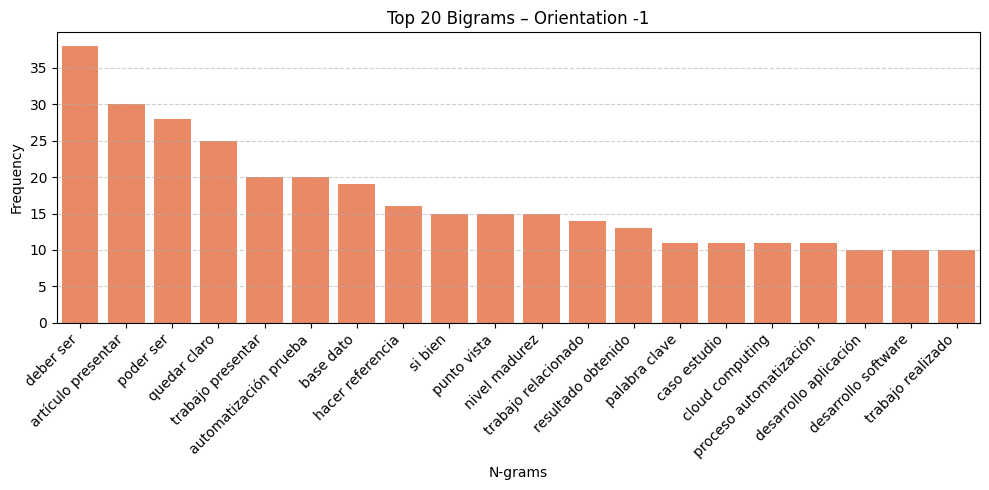

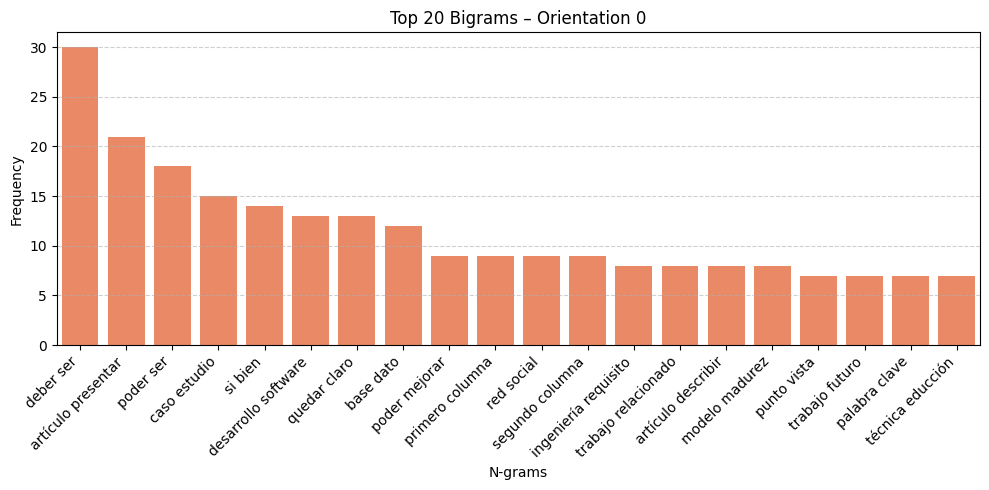

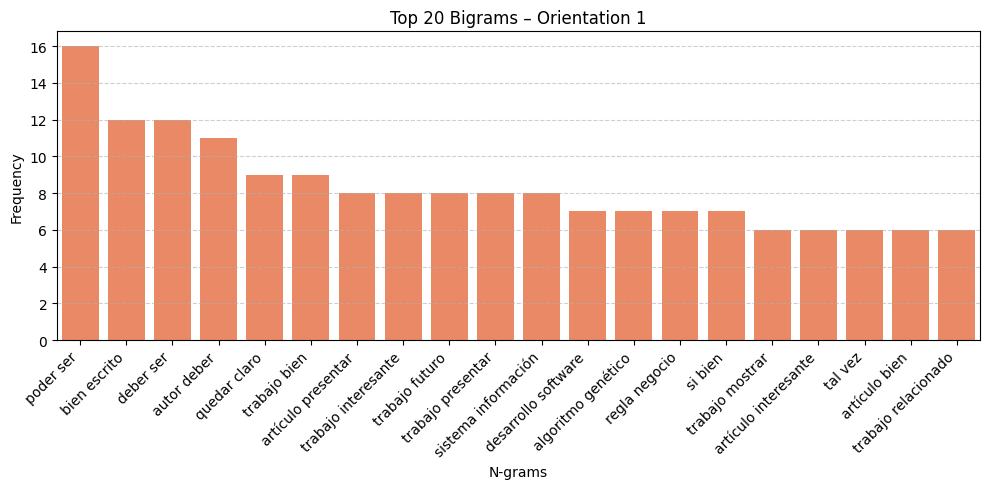

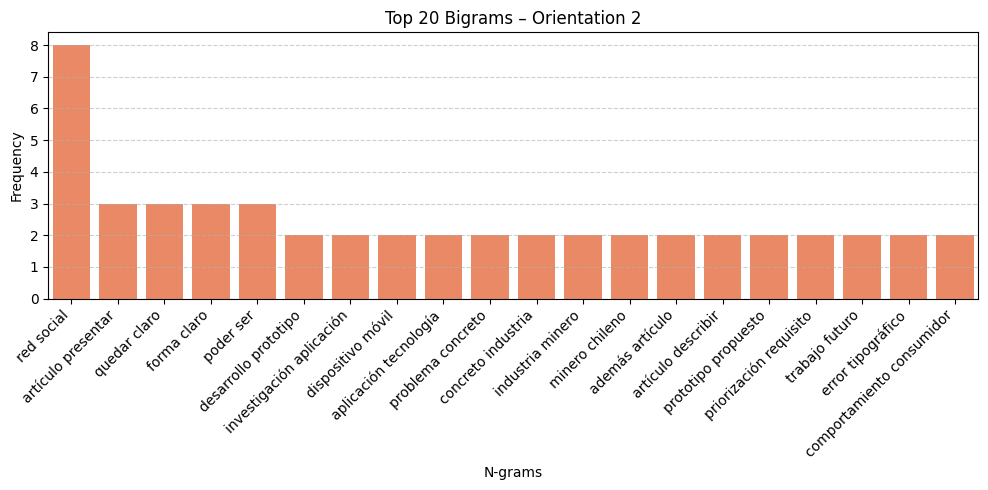

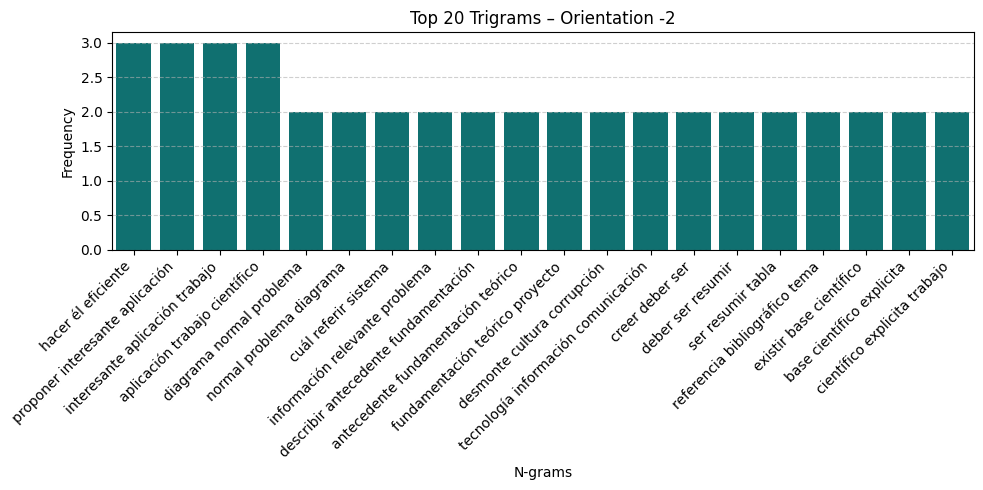

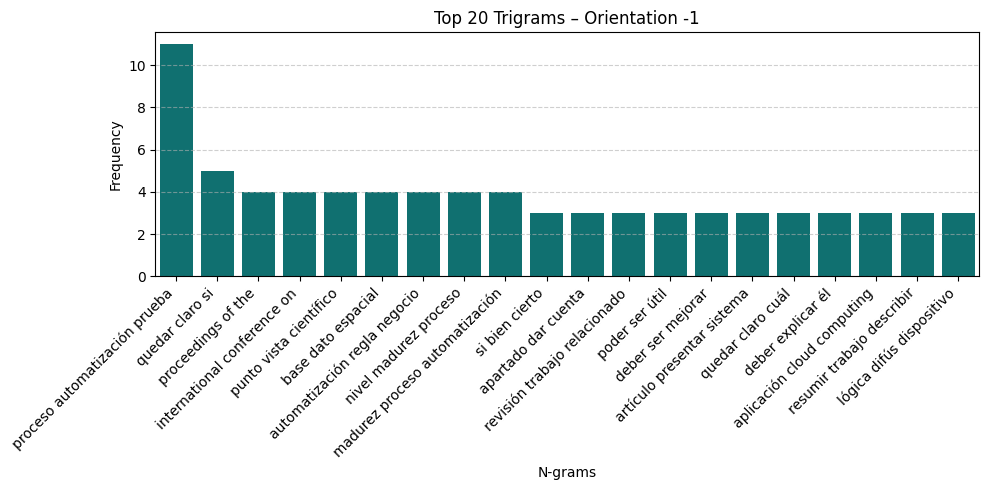

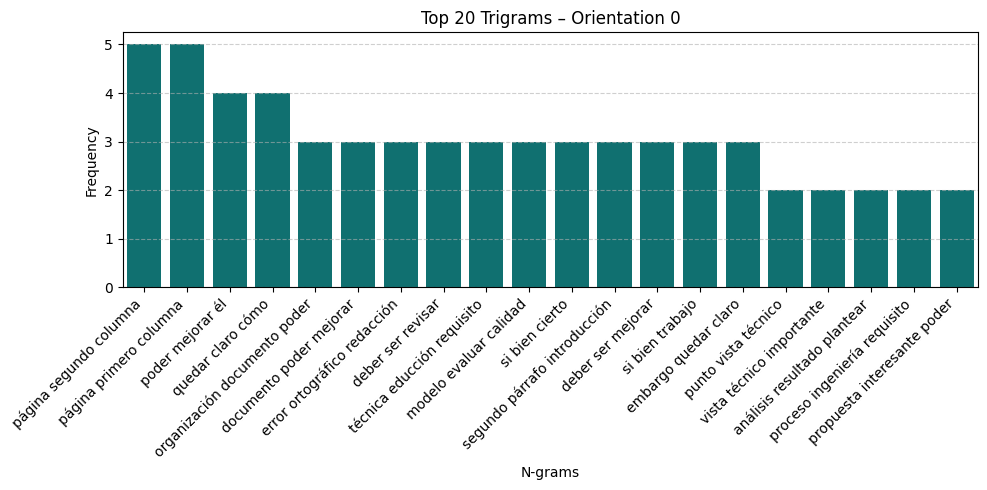

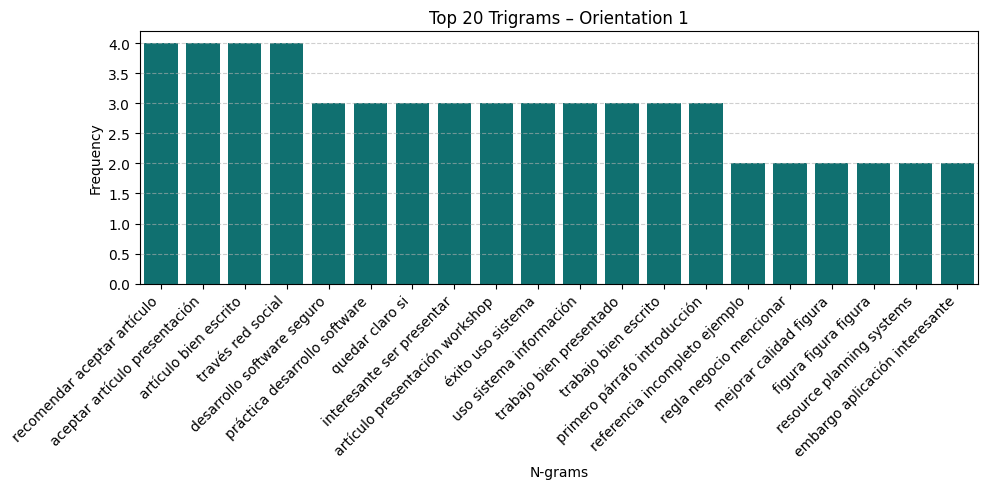

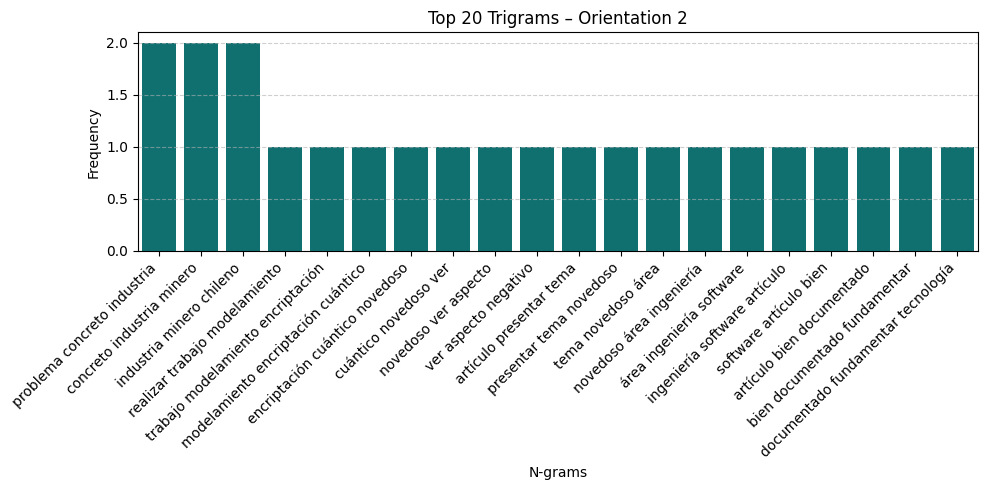

In [7]:
#Phase 4: N-gram Analysis (Bigrams & Trigrams)
from sklearn.feature_extraction.text import CountVectorizer

# Function to extract top n-grams
def get_top_ngrams(corpus, ngram_range=(2, 2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

def plot_ngrams(ngrams, title, color='coral'):
    words, counts = zip(*ngrams)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(words), y=list(counts), color=color)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("N-grams")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Bigrams by sentiment
for sentiment in sorted(df_cleaned['orientation'].unique()):
    subset = df_cleaned[df_cleaned['orientation'] == sentiment]['cleaned_text']
    bigrams = get_top_ngrams(subset, ngram_range=(2, 2), n=20)
    plot_ngrams(bigrams, f"Top 20 Bigrams – Orientation {sentiment}")

# Trigrams by sentiment
for sentiment in sorted(df_cleaned['orientation'].unique()):
    subset = df_cleaned[df_cleaned['orientation'] == sentiment]['cleaned_text']
    trigrams = get_top_ngrams(subset, ngram_range=(3, 3), n=20)
    plot_ngrams(trigrams, f"Top 20 Trigrams – Orientation {sentiment}", color='teal')


STEP-3: Feature Engineering

Goal: Building a full feature matrix X (text + numeric), and defining a target y.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np

# === Step 5.1: TF-IDF Vectorization ===
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)  # Unigrams + bigrams
X_text = tfidf.fit_transform(df_cleaned['cleaned_text'])

# === Step 5.2: Add numeric features ===
numeric_features = ['word_count', 'char_count', 'confidence', 'evaluation']
df_cleaned[numeric_features] = df_cleaned[numeric_features].fillna(0)

# Force numeric types
for col in numeric_features:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

X_numeric = df_cleaned[numeric_features].values.astype('float64')

# === Step 5.3: Combine text + numeric features ===
X = hstack([X_text, X_numeric])


# === Step 5.4: Define Target Variable ===
y = df_cleaned['orientation']

# === Step 5.5: Sanity Check ===
print("Final Feature Matrix shape (X):", X.shape)
print("Target Vector shape (y):", y.shape)
print("Sample of numeric features:\n", df_cleaned[numeric_features].head())


Final Feature Matrix shape (X): (399, 5004)
Target Vector shape (y): (399,)
Sample of numeric features:
    word_count  char_count  confidence  evaluation
0          45         575           4           1
1          50         618           4           1
2         118        1259           5           1
3         119        1350           4           2
4         162        1938           4           2


STEP-4:MODELLING
1.Logistic Regression – Full Pipeline


✅ Logistic Regression model trained successfully!
🎯 Accuracy: 0.5500

📝 Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         7
          -1       0.62      0.69      0.66        29
           0       0.47      0.32      0.38        22
           1       0.52      0.74      0.61        19
           2       0.50      1.00      0.67         3

    accuracy                           0.55        80
   macro avg       0.42      0.55      0.46        80
weighted avg       0.50      0.55      0.51        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/IPython/c

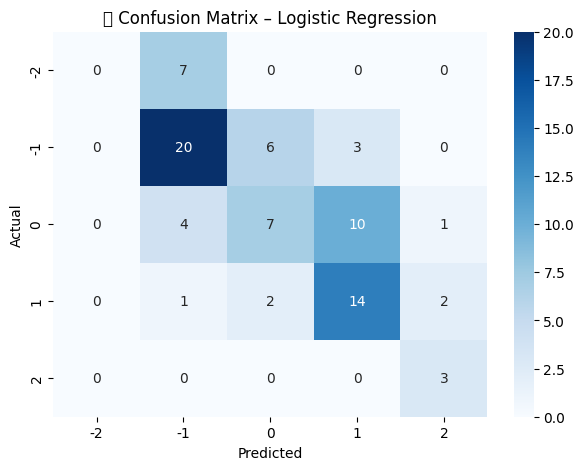

In [9]:
# STEP 6: Logistic Regression – Optimized Final Version

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === 6.1: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 6.2: Initialize Logistic Regression ===
logreg = LogisticRegression(
    max_iter=1000,               # Enough iterations to converge
    solver='liblinear',          # Works well for small/medium datasets
    class_weight='balanced',     # Handles class imbalance
    C=1.0                        # Regularization strength (default, balanced)
)

# === 6.3: Train the model ===
logreg.fit(X_train, y_train)
print("✅ Logistic Regression model trained successfully!")

# === 6.4: Make Predictions ===
y_pred = logreg.predict(X_test)

# === 6.5: Evaluate the Model ===
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {acc:.4f}\n")

print("📝 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📊 Confusion Matrix – Logistic Regression")
plt.show()
